In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import json
import pandas as pd

from load_data import BiopsyDataset, DATA_DIR, TRANSFORMS, P53_CLASS_NAMES
from resnet import ResNetModel, ResNetModelDoubleBinary

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print("Device: {}".format(device))

C:\Users\321lu\AppData\Local\Temp\ipykernel_2960\41376266.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Device: cuda
Device: cuda


In [9]:
# Load labels
labels = pd.read_csv(os.path.join(DATA_DIR, 'biopsy_labels_s1.0_anon.csv'))

# We're going to make a balanced test set
# Additionally, each slide (the first number in the 0_0 id format) should only appear in one of the sets
# We'll do this by taking all of the slides that contain the most extreme minority class,
# putting them in the test set, counting how many biopsies of the other classes we still need to fill the test set,
# and then randomly adding slides that contain those classes one by one until we have enough
# We'll then remove all of the test set slides from the training set

# Get the number of biopsies in each class
class_counts = labels['label'].value_counts()
print("Class counts:")
print(class_counts)
# Get the class with the fewest biopsies
minority_class = class_counts.idxmin()
minority_class_count = class_counts[minority_class]
print("Minority class: {}".format(minority_class))
print("Minority class count: {}".format(minority_class_count))

# Get the slides that contain the minority class
minority_slides = labels[labels['label'] == minority_class]['id'].str.split('_').str[0].unique()
print("Slides containing the minority class:")
print(minority_slides)
print("Number of slides containing the minority class: {}".format(len(minority_slides)))
test_set = minority_slides

# In a loop:
# Get the class distribution of the test set with these slides
# Get the new minority class count for the test set
# Add one slide that contains the minority class to the test set
# Repeat until this new minority class count is greater than the minority class count
while True:
    # Get the class distribution of the test set with these slides
    test_labels = labels[labels['id'].str.split('_').str[0].isin(test_set)]
    test_class_counts = test_labels['label'].value_counts()
    print("Class counts in the test set:")
    print(test_class_counts)
    # Get the new minority class count for the test set
    new_minority_class = test_class_counts.idxmin()
    new_minority_class_count = test_class_counts[new_minority_class]
    print("New minority class count: {}".format(new_minority_class_count))
    # If the new minority class count is greater than the minority class count, break
    if new_minority_class_count >= minority_class_count:
        break
    # Add one random slide that contains the minority class to the test set
    new_slide = labels[labels['label'] == new_minority_class]['id'].str.split('_').str[0].sample(1).values[0]
    test_set = np.append(test_set, new_slide)
    print("Added slide {} to the test set".format(new_slide))
    print("Number of slides in the test set: {}".format(len(test_set)))

Class counts:
label
0    1623
1     378
2     159
3      54
Name: count, dtype: int64
Minority class: 3
Minority class count: 54
Slides containing the minority class:
['12' '60' '83' '90' '97' '100' '106' '110' '112' '128' '131' '137' '139'
 '146' '168' '173' '175' '176' '182' '185' '187' '190' '195' '196' '199'
 '204' '209' '220' '232' '234' '235' '237' '248' '254' '262' '265' '449'
 '450' '468' '473' '502' '572' '574' '581' '592']
Number of slides containing the minority class: 45
Class counts in the test set:
label
0    72
3    54
1    25
2    16
Name: count, dtype: int64
New minority class count: 16
Added slide 317 to the test set
Number of slides in the test set: 46
Class counts in the test set:
label
0    75
3    54
1    25
2    17
Name: count, dtype: int64
New minority class count: 17
Added slide 535 to the test set
Number of slides in the test set: 47
Class counts in the test set:
label
0    76
3    54
1    25
2    19
Name: count, dtype: int64
New minority class count: 19
Added

In [11]:
# Save the test set subset from the labels as a csv
test_labels = labels[labels['id'].str.split('_').str[0].isin(test_set)]
test_labels.to_csv(os.path.join(DATA_DIR, 'test.csv'), index=False)
# Save the train set subset from the labels as a csv (all of the slides that aren't in the test set)
train_labels = labels[~labels['id'].str.split('_').str[0].isin(test_set)]
train_labels.to_csv(os.path.join(DATA_DIR, 'train.csv'), index=False)

In [16]:
# Use Laplacian variance to measure blurriness
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

variances = {}

biopsy_dir = os.path.join(DATA_DIR, '..', 'p53_consensus_study', 'biopsies')
for img_path in tqdm(os.listdir(biopsy_dir)):
    img_path = os.path.join(biopsy_dir, img_path)
    img_name = os.path.basename(img_path).split('.')[0]
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(gray)

    variances[img_name] = fm

100%|██████████| 628/628 [01:52<00:00,  5.60it/s]


In [13]:
# Sort by variance
sorted_variances = {k: v for k, v in sorted(variances.items(), key=lambda item: item[1])}

with open(os.path.join(biopsy_dir, '..', 'variances.json'), 'w') as f:
    json.dump(sorted_variances, f)

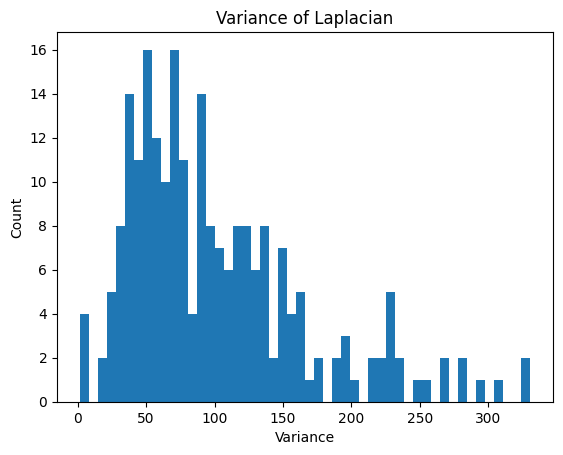

In [14]:
# Plot the variance distribution
plt.figure()
plt.hist(list(sorted_variances.values()), bins=50)
plt.title("Variance of Laplacian")
plt.xlabel("Variance")
plt.ylabel("Count")
plt.show()

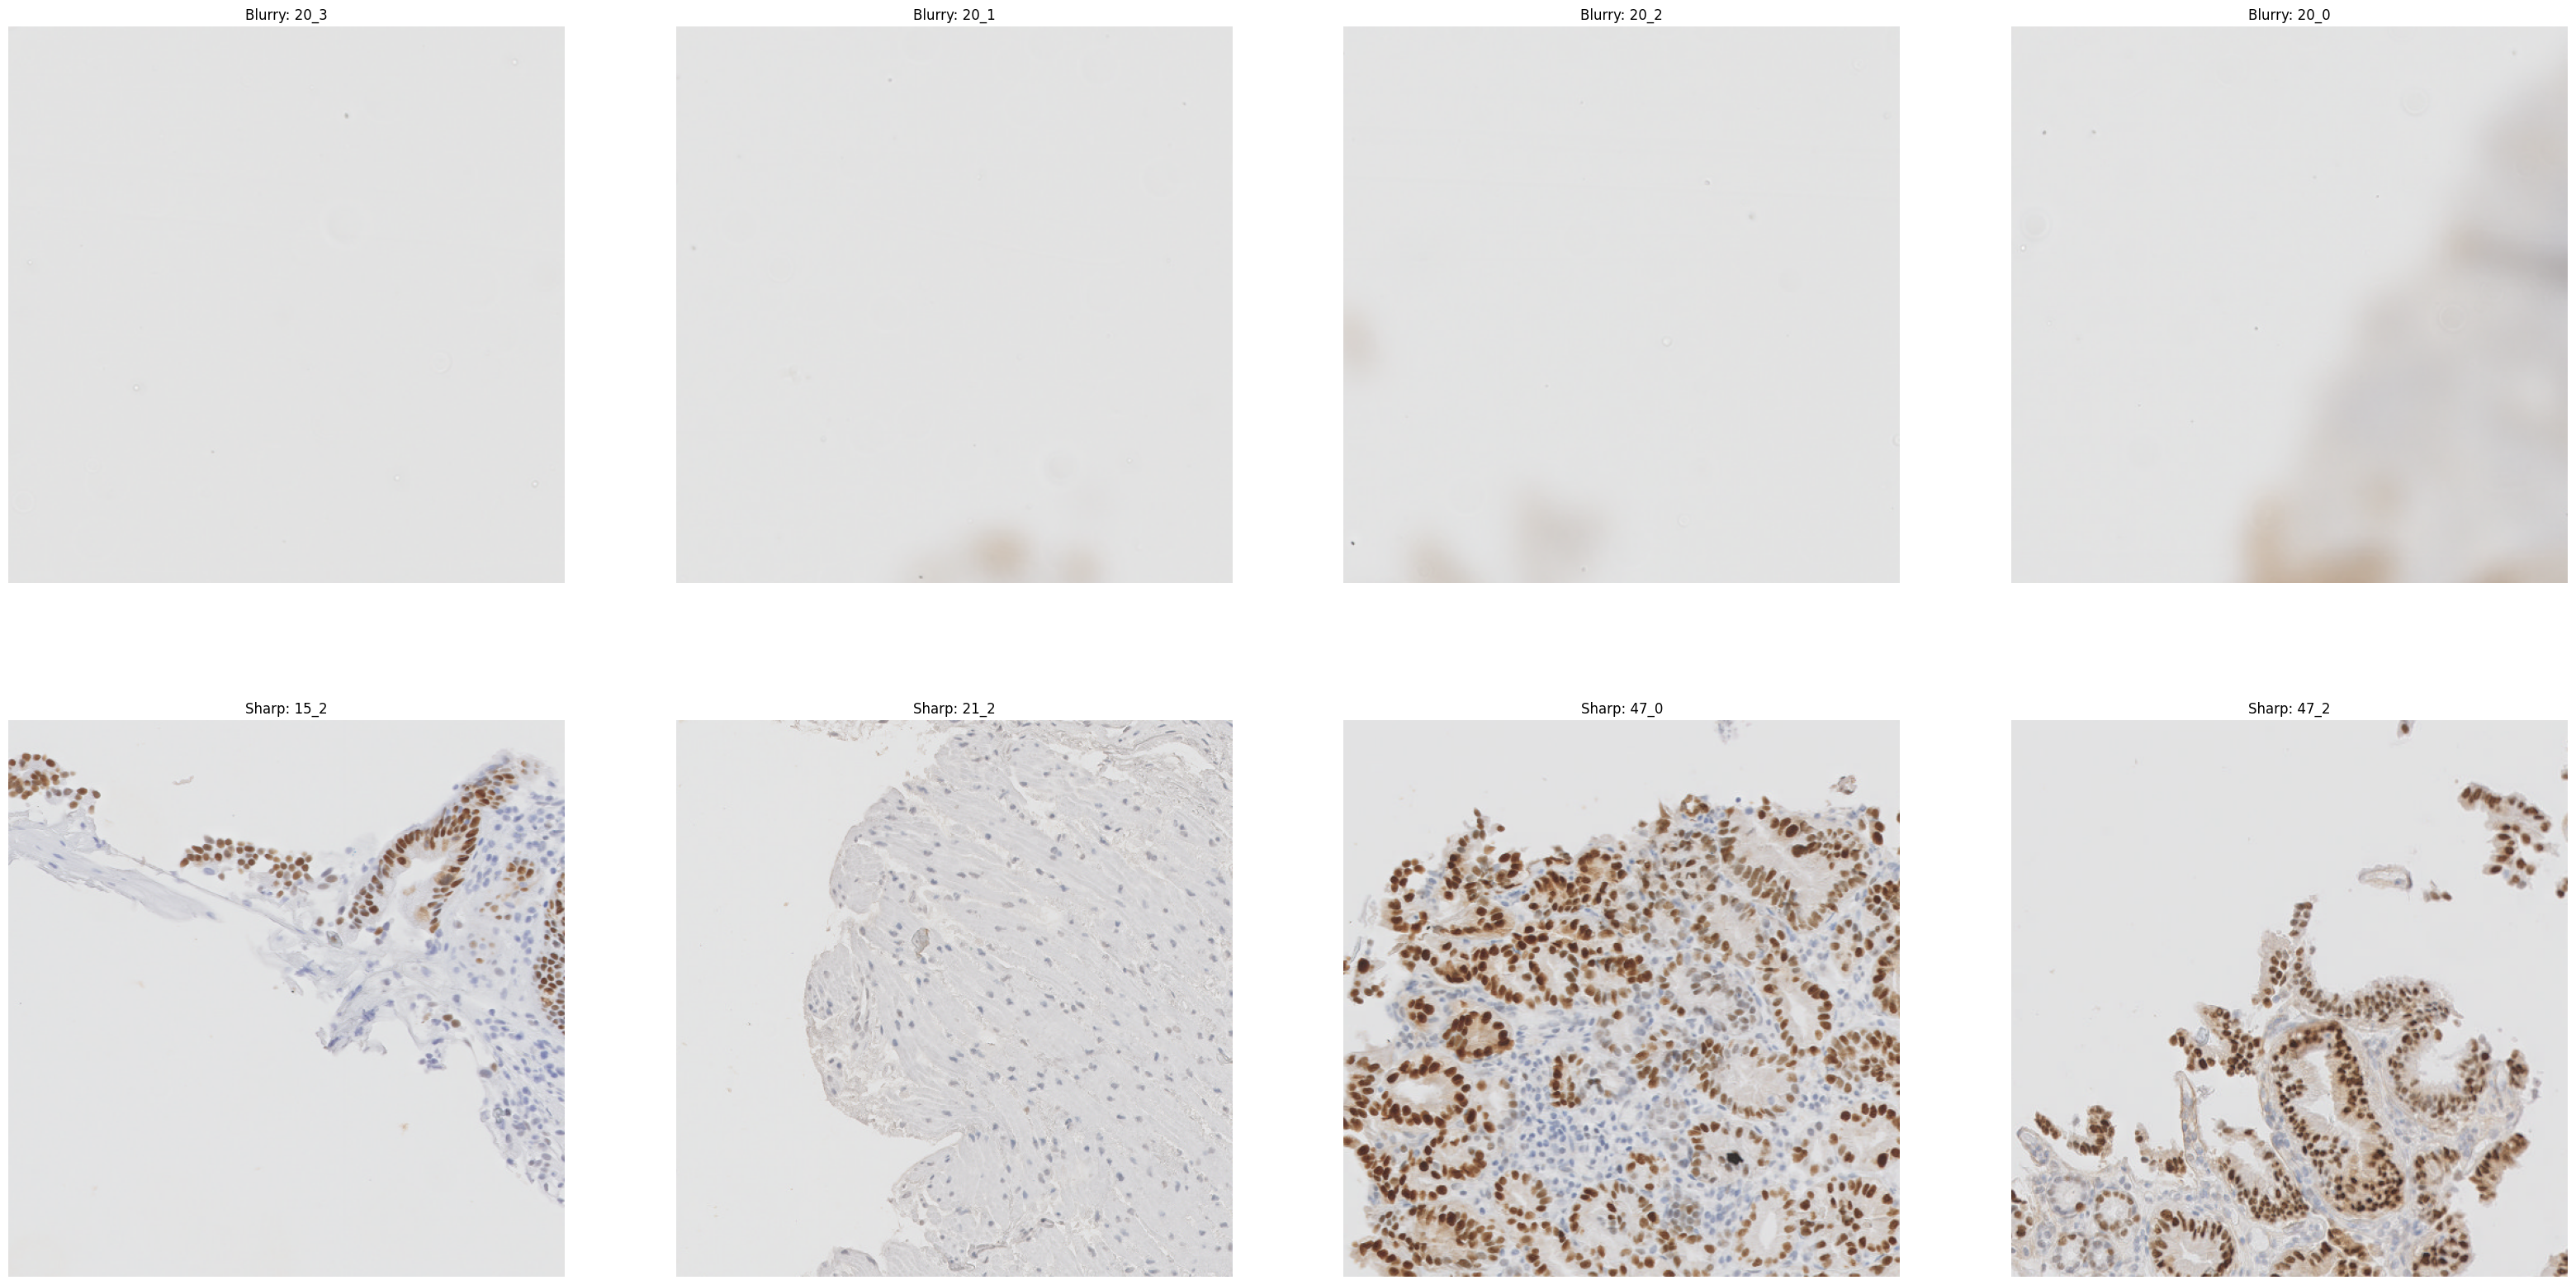

In [15]:
# Plot the 4 most blurry images, and the 4 least blurry images
blurry_img_names = list(sorted_variances.keys())[:4]
sharp_img_names = list(sorted_variances.keys())[-4:]

fig, axs = plt.subplots(2, 4, figsize=(40, 20))
for i, img_name in enumerate(blurry_img_names):
    img_path = os.path.join(biopsy_dir, img_name + '.png')
    img = cv2.imread(img_path)
    # Select the middle 512x512 region
    img = img[256:768, 256:768]
    axs[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0, i].set_title("Blurry: {}".format(img_name))
    axs[0, i].axis('off')

for i, img_name in enumerate(sharp_img_names):
    img_path = os.path.join(biopsy_dir, img_name + '.png')
    img = cv2.imread(img_path)
    # Select the middle 512x512 region
    img = img[256:768, 256:768]
    axs[1, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[1, i].set_title("Sharp: {}".format(img_name))
    axs[1, i].axis('off')

plt.show()

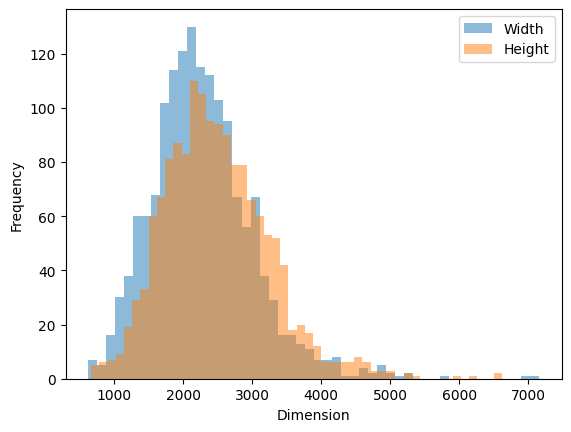

Total number of biopsies: 1532
Number of biopsies with largest dimension < 4096: 1451
Number of biopsies with largest dimension < 4500: 1485
Number of biopsies with largest dimension < 5000: 1518
Max dimension: [7160, 2778]
Biopsy with largest dimension: 828


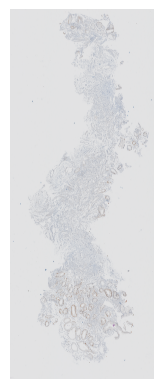

In [2]:
with open(os.path.join(DATA_DIR, 'biopsy_dims.json'), 'r') as f:
    biopsy_dims = json.load(f) # Dict of biopsy_id: (width, height)

# Show distribution of biopsy dimensions
widths = [dim[0] for dim in biopsy_dims.values()]
heights = [dim[1] for dim in biopsy_dims.values()]
plt.hist(widths, bins=50, alpha=0.5, label='Width')
plt.hist(heights, bins=50, alpha=0.5, label='Height')
plt.xlabel('Dimension')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Total number of biopsies
num_biopsies = len(biopsy_dims)
print("Total number of biopsies: {}".format(num_biopsies))
# Number of biopsies with largest dimension < 4000, < 4500 and < 5000
num_biopsies_4000 = sum([max(dims) < 4096 for dims in zip(widths, heights)])
num_biopsies_4500 = sum([max(dims) < 4500 for dims in zip(widths, heights)])
num_biopsies_5000 = sum([max(dims) < 5000 for dims in zip(widths, heights)])
print("Number of biopsies with largest dimension < 4096: {}".format(num_biopsies_4000))
print("Number of biopsies with largest dimension < 4500: {}".format(num_biopsies_4500))
print("Number of biopsies with largest dimension < 5000: {}".format(num_biopsies_5000))

# Find largest dimension
max_dim = max(biopsy_dims.values())
print("Max dimension: {}".format(max_dim))
# Index of largest dimension
max_dim_idx = list(biopsy_dims.values()).index(max_dim)
# Image with largest dimension
max_dim_img = list(biopsy_dims.keys())[max_dim_idx]
print("Biopsy with largest dimension: {}".format(max_dim_img))

# Show image with largest dimension
img = cv2.imread(os.path.join(DATA_DIR, "biopsies", f"{max_dim_img}.png"))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [3]:
class BiopsyConstantResizeDataset(torch.utils.data.Dataset):
    """Biopsy dataset. getitem returns (image, label) tuples."""
    def __init__(self, root_dir, labels_filename="test", transform=None, class_names=None, size=2048, size_limit=4096, data_limit=None, latents_path=None, fill_bg=0.5):
        """
        Args:
            root_dir (string): Directory with all the biopsies.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.latents_path = latents_path
        if latents_path:
            print("Loading from latents")
            print("transforms are ignored")

        self.size = size
        self.size_limit = size_limit
        self.fill_bg = fill_bg
        
        # Read the labels
        labels_file = os.path.join(root_dir, f"{labels_filename}.csv")
        self.labels = np.loadtxt(labels_file, delimiter=",", skiprows=1)
        self.labels = self.labels.astype(int)
        if data_limit:
            self.labels = self.labels[:data_limit]

        self.num_classes = len(np.unique(self.labels[:, 1]))
        if class_names and self.num_classes != len(class_names):
            self.num_classes = len(class_names)
        self.class_names = class_names

        # Filter out indices of biopsies that exceed the size limit
        with open(os.path.join(DATA_DIR, "biopsy_dims.json"), 'r') as f:
            biopsy_dims = json.load(f)
        filtered_labels = []
        max_dim = 0
        for idx, label in self.labels:
            w_h = biopsy_dims[str(idx)]
            if max(w_h) > size_limit:
                continue
            max_dim = max(max_dim, max(w_h))
            filtered_labels.append([idx, label])
        self.labels = np.array(filtered_labels)
        resize_divisor = max_dim / size

        self.class_distribution = {i: np.sum(self.labels[:, 1] == i) for i in range(self.num_classes)}
        if class_names:
            self.class_distribution = {class_names[i]: self.class_distribution[i] for i in range(self.num_classes)}
        print("Class distribution: ", self.class_distribution)

        if latents_path:
            self.latents = torch.load(os.path.join(root_dir, latents_path)) # (n, 4, ftrs)
            self.latents = self.latents[self.labels[:, 0]] # Only keep the latents for the images in the dataset
            return

        # If self.imgs is already pickled, load it
        imgs_file = os.path.join(root_dir, f"imgs_{labels_filename}_{size}_sl{size_limit}.pt")
        if os.path.exists(imgs_file):
            self.imgs = torch.load(imgs_file)
            print("Loaded images from file")
        else:
            print("Processing images")
            # Read the images
            imgs_dir = os.path.join(root_dir, "biopsies")
            self.imgs = []
            for idx in tqdm(self.labels[:, 0]):
                img_file = os.path.join(imgs_dir, f"{idx}.png")
                img = plt.imread(img_file)
                img = torch.tensor(img).permute(2, 0, 1).float()
                dims = int(img.shape[1] / resize_divisor), int(img.shape[2] / resize_divisor)
                img = torch.nn.functional.interpolate(img.unsqueeze(0), size=dims).squeeze(0)
                self.imgs.append(img)
            
            # Save the images to a file
            torch.save(self.imgs, imgs_file)

        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = int(self.labels[idx, 1])

        if self.latents_path:
            return (self.latents[idx], label)

        image = self.imgs[idx]
        # Place image in self.size x self.size square without resizing
        h, w = image.shape[1], image.shape[2]
        frame = torch.zeros(3, self.size, self.size).fill_(self.fill_bg)
        # img_mean = image.mean(dim=(1, 2))
        # frame[:, :, :] = img_mean.view(3, 1, 1)
        # Center image in frame
        x_start = (self.size - w) // 2
        y_start = (self.size - h) // 2
        frame[:, y_start:y_start+h, x_start:x_start+w] = image
        image = frame
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

    def plot_example_grid(self, n=5, random=True, figsize=(15, 15)):
        """Plot a grid with n*n examples."""
        if self.latents_path:
            print("Cannot plot examples from latents")
            return

        if random:
            indices = np.random.choice(len(self), size=n*n, replace=False)
        else:
            indices = np.arange(n*n)
        
        fig, axs = plt.subplots(n, n, figsize=figsize)
        for i, ax in enumerate(axs.flatten()):
            img = self[indices[i]][0].permute(1, 2, 0)
            ax.imshow(img)
            ax.set_title(self.class_names[self[indices[i]][1]] + f"\n{list(img.shape[:-1])}")
            ax.axis("off")
        plt.show()

Class distribution:  {'Wildtype': 13, 'Overexpression': 13, 'Nullmutation': 14, 'Doubleclone': 15}
Loaded images from file


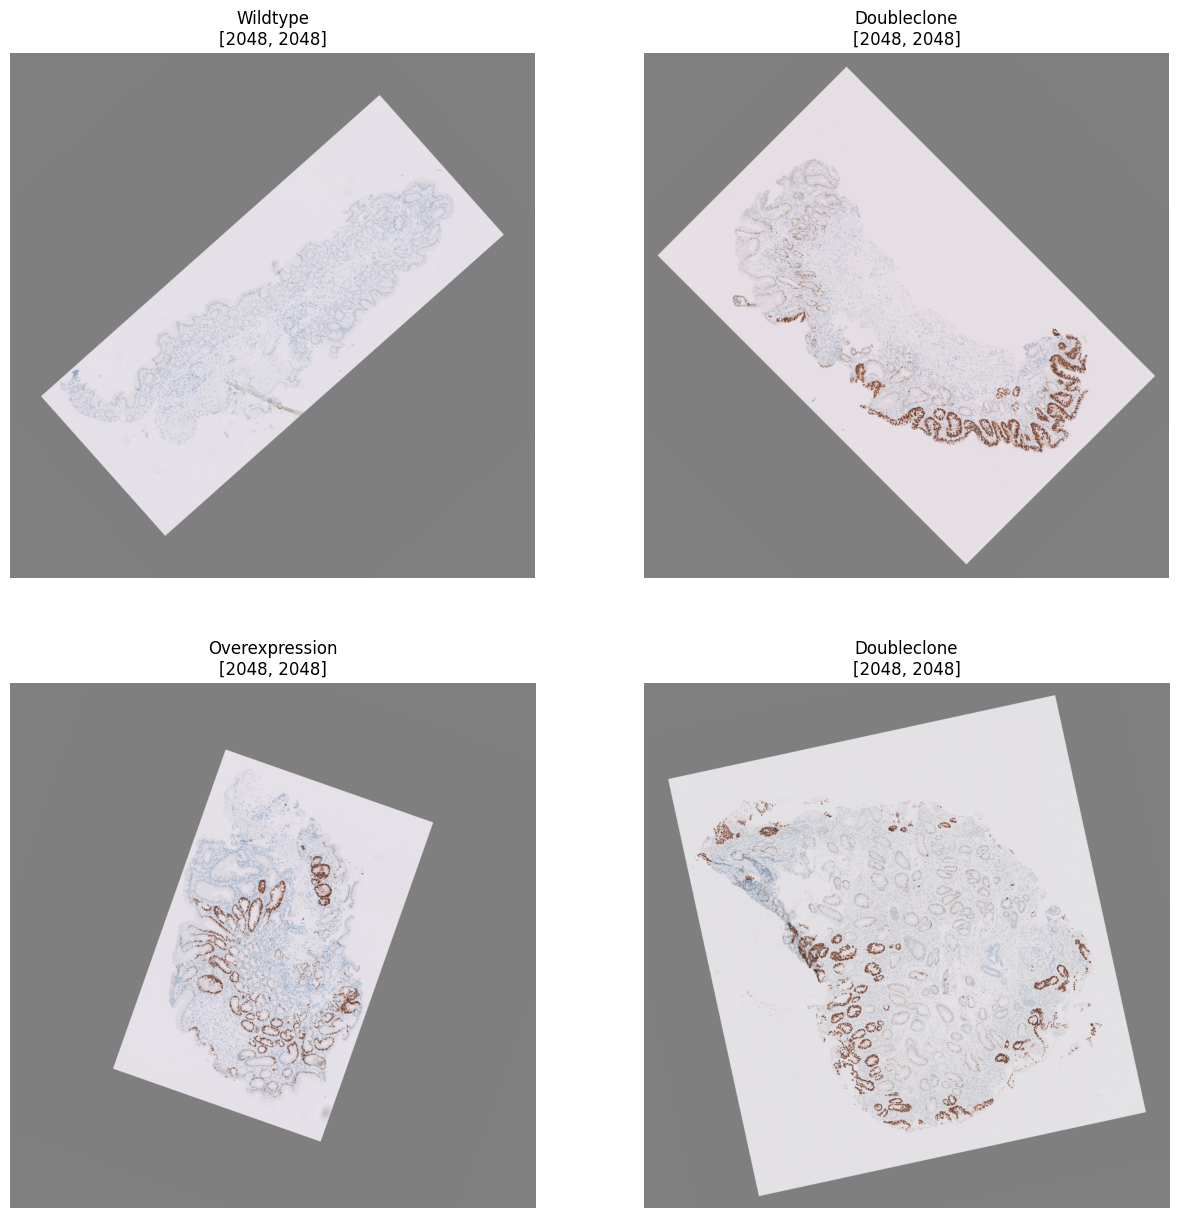

In [5]:
import torchvision.transforms as transforms

test_dataset = BiopsyDataset(DATA_DIR, class_names=P53_CLASS_NAMES, transform=TRANSFORMS["rotation_grey"])
test_dataset.plot_example_grid(2)

In [ ]:
5344 * 4832

In [ ]:
# Calculate size on disk for all biopsies if resized to 1024x1024
# Filetype is PNG, so 3 bytes per pixel
size_on_disk = 0
for biopsy_id, dims in biopsy_dims.items():
    if max(dims) > 4096:
        continue
    img_size = dims[0] * dims[1] / 4
    # img_size = 1024**2
    size_on_disk += img_size
print("Size on disk for all biopsies: {} bytes".format(size_on_disk))
print("Size on disk for all biopsies: {} MB".format(size_on_disk / 1024**2))
print("Size on disk for all biopsies: {} GB".format(size_on_disk / 1024**3))

In [ ]:
# Calculate size on disk for all biopsies if resized to 1024x1024
# Filetype is PNG, so 3 bytes per pixel
size_on_disk = 0
for biopsy_id, dims in biopsy_dims.items():
    # img_size = 2048**2
    img_size = min(dims[0],2048) * min(dims[1],2048)
    size_on_disk += img_size
print("Size on disk for all biopsies: {} bytes".format(size_on_disk))
print("Size on disk for all biopsies: {} MB".format(size_on_disk / 1024**2))
print("Size on disk for all biopsies: {} GB".format(size_on_disk / 1024**3))

# Patch Label Dataset

In [9]:
class PatchDataset(torch.utils.data.Dataset):
    """
    Biopsy patch dataset with overexpression and nullmutation labels.

    getitem returns (patch latent, patch label) tuples, 
        where patch latent is a vector of shape (2048),
        patch label is a vector of shape (2) with the overexpression and nullmutation labels.
    """
    def __init__(self, root_dir, labels_filename="train", data_limit=None, **kwargs):
        """
        Args:
            root_dir (string): Directory with all the biopsies.
        """
        self.root_dir = root_dir

        # Read the labels
        labels_file = os.path.join(root_dir, f"{labels_filename}.csv")
        self.labels = np.loadtxt(labels_file, delimiter=",", skiprows=1)
        self.labels = self.labels.astype(int)
        if data_limit:
            self.labels = self.labels[:data_limit]
        
        # bag_latents_file = os.path.join(root_dir, f"bag_latents_gs256_retccl_relaxed.pt")
        # bag_patch_indices_file = os.path.join(root_dir, f"non_empty_patch_indices_gs256_relaxed.pt")
        bag_latents_file = os.path.join(root_dir, f"bag_latents_gs256_retccl__backup.pt")
        bag_patch_indices_file = os.path.join(root_dir, f"non_empty_patch_indices_gs256.pt")
        oe_patch_indices_file = os.path.join(root_dir, f"oe_patch_indices_gs256.pt")
        nm_patch_indices_file = os.path.join(root_dir, f"nm_patch_indices_gs256.pt")
        for file in [bag_latents_file, bag_patch_indices_file, oe_patch_indices_file, nm_patch_indices_file]:
            if not os.path.exists(file):
                print("File does not exist at", file)
                return
        
        bag_latents       = torch.load(bag_latents_file)        # dict of idx: [(ftrs,), (ftrs,), ...]
        bag_patch_indices = torch.load(bag_patch_indices_file)  # dict of idx: [patch_idx, patch_idx, ...]
        oe_patch_indices  = torch.load(oe_patch_indices_file)   # dict of idx: [patch_idx, patch_idx, ...]
        nm_patch_indices  = torch.load(nm_patch_indices_file)   # dict of idx: [patch_idx, patch_idx, ...]

        self.patch_latents = []
        self.patch_labels = []
        for idx, label in tqdm(self.labels):
            if label == 0: # Wildtype, use all patches
                self.patch_latents.extend(bag_latents[idx])
                self.patch_labels.extend([(0, 0)] * len(bag_latents[idx]))
            elif label == 1: # Overexpression, use only overexpression patches
                oe_indices = [bag_patch_indices[idx].tolist().index(oe_idx) for oe_idx in oe_patch_indices[idx] if oe_idx in bag_patch_indices[idx]]
                self.patch_latents.extend([bag_latents[idx][i] for i in oe_indices])
                self.patch_labels.extend([(1, 0)] * len(oe_indices))
            elif label == 2: # Nullmutation, use only nullmutation patches
                nm_indices = [bag_patch_indices[idx].tolist().index(nm_idx) for nm_idx in nm_patch_indices[idx] if nm_idx in bag_patch_indices[idx]]
                self.patch_latents.extend([bag_latents[idx][i] for i in nm_indices])
                self.patch_labels.extend([(0, 1)] * len(nm_indices))
            elif label == 3: # Both, use patches from both overexpression and nullmutation
                oe_indices = [bag_patch_indices[idx].tolist().index(oe_idx) for oe_idx in oe_patch_indices[idx] if oe_idx in bag_patch_indices[idx]]
                nm_indices = [bag_patch_indices[idx].tolist().index(nm_idx) for nm_idx in nm_patch_indices[idx] if nm_idx in bag_patch_indices[idx]]
                self.patch_latents.extend([bag_latents[idx][i] for i in oe_indices + nm_indices])
                self.patch_labels.extend([(1, 0)] * len(oe_indices) + [(0, 1)] * len(nm_indices))
        self.patch_latents = torch.stack(self.patch_latents) # (n, ftrs)
        self.patch_labels = torch.tensor(self.patch_labels).float() # (n, 2)

        self.wt_indices = torch.nonzero((self.patch_labels[:, 0] == 0) & (self.patch_labels[:, 1] == 0)).squeeze()
        self.oe_indices = torch.nonzero(self.patch_labels[:, 0] == 1).squeeze()
        self.nm_indices = torch.nonzero(self.patch_labels[:, 1] == 1).squeeze()
        self.class_distribution = {
            "wildtype": len(self.wt_indices),
            "any overexpression": len(self.oe_indices),
            "any nullmutation": len(self.nm_indices),
            "total": len(self.patch_labels)
        }
        print("Class distribution: ", self.class_distribution)
        
        
    def __len__(self):
        return len(self.patch_labels)
    
    def __getitem__(self, idx):
        patch_latent = self.patch_latents[idx] # (ftrs,)
        patch_label = self.patch_labels[idx] # (2,)

        return (patch_latent, patch_label)

    def plot_example_grid(self, n=3, random=True, figsize=(15, 15)):
        """Plot a grid with n*n examples."""
        print("Cannot plot examples from latents")
        return

        assert n%3 == 0, "n must be divisible by 3"
        if random:
            wt_indices = self.wt_indices[np.random.choice(len(self.wt_indices), size=n*n//2, replace=False)]
            oe_indices = self.oe_indices[np.random.choice(len(self.oe_indices), size=n*n//2, replace=False)]
            nm_indices = self.nm_indices[np.random.choice(len(self.nm_indices), size=n*n//2, replace=False)]
        else:
            wt_indices = self.wt_indices[:n*n//2]
            oe_indices = self.oe_indices[:n*n//2]
            nm_indices = self.nm_indices[:n*n//2]
        
        fig, axs = plt.subplots(n, n, figsize=figsize)
        for i, ax in enumerate(axs.flatten()):
            if i < n*n//3:
                label = "wildtype"
                indices = wt_indices
                idx = i
            elif i < 2*n*n//3:
                label = "overexpression"
                indices = oe_indices
                idx = i - n*n//3
            else:
                label = "nullmutation"
                indices = nm_indices
                idx = i - 2*n*n//3
                # print(indices[idx], self[indices[idx]][1].mean())
                
            patch, patch_label = self[indices[idx]]
            ax.imshow(patch.squeeze().permute(1, 2, 0))
            ax.set_title(f"Wildtype")
            if label == "nullmutation":
                ax.imshow(patch_label[0], alpha=0.5, vmin=0, vmax=1, cmap="Reds")
                ax.set_title(f"Nullmutation [{patch_label.mean():.2f}]")
            ax.axis("off")
        plt.show()

In [10]:
patch_dataset = PatchDataset(DATA_DIR, class_names=P53_CLASS_NAMES)

100%|██████████| 1472/1472 [00:00<00:00, 3656.55it/s]


Class distribution:  {'wildtype': 61970, 'any overexpression': 3269, 'any nullmutation': 1039, 'total': 66278}


In [11]:
patch_dataset_test = PatchDataset(DATA_DIR, class_names=P53_CLASS_NAMES, labels_filename="test")

100%|██████████| 60/60 [00:00<00:00, 2615.83it/s]

Class distribution:  {'wildtype': 792, 'any overexpression': 476, 'any nullmutation': 405, 'total': 1673}
